In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
teen_mental_health_df=pd.read_csv('/content/final_teen_mental_health_chatbot_dataset.csv')
print(teen_mental_health_df.head())
print("**************************")
print(f"The shape of the dataset is : {teen_mental_health_df.shape}")

                            user_input  \
0              I feel really sad today   
1             I’m stressed about exams   
2                       I feel anxious   
3  My friends don’t talk to me anymore   
4           I’m so tired of everything   

                                        bot_response  
0  I'm so sorry to hear that. Can you share what’...  
1  That sounds overwhelming. Let’s talk about wha...  
2  I hear you. It’s okay to feel anxious sometime...  
3  That must hurt. I'm here for you. Want to talk...  
4  I'm really sorry you're feeling this way. You'...  
**************************
The shape of the dataset is : (287, 2)


In [ ]:
teen_mental_health_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_input    287 non-null    object
 1   bot_response  287 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


In [ ]:
print(teen_mental_health_df.isnull().sum())

user_input      0
bot_response    0
dtype: int64


# **Text Preprocessing**
* Converting to lowercase
* Removal of Stopwords
* Lemmatization  

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

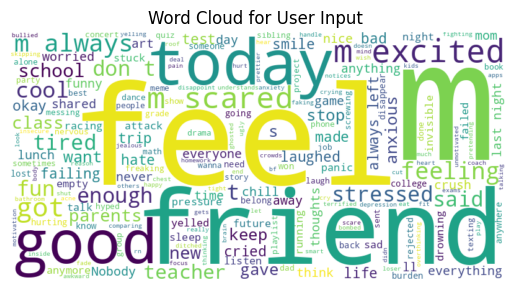

********************************************************************************
--------------------------------------------------------------------------------


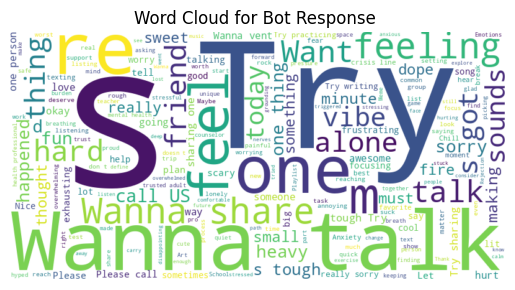

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(teen_mental_health_df['user_input']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for User Input ')
plt.show()
print("*"*80)
print("-"*80)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(teen_mental_health_df['bot_response']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Bot Response ')
plt.show()

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):

    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    tokens = word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(cleaned_tokens)


teen_mental_health_df["cleaned_user_input"] = teen_mental_health_df["user_input"].apply(preprocess_text)
teen_mental_health_df["cleaned_bot_response"]=teen_mental_health_df["bot_response"].apply(preprocess_text)

teen_mental_health_df[["user_input", "cleaned_user_input"]].head()


,user_input,cleaned_user_input
0,I feel really sad today,feel really sad today
1,I’m stressed about exams,im stressed exam
2,I feel anxious,feel anxious
3,My friends don’t talk to me anymore,friend dont talk anymore
4,I’m so tired of everything,im tired everything


In [ ]:
teen_mental_health_df['cleaned_bot_response'].head(20)

,cleaned_bot_response
0,im sorry hear share whats going
1,sound overwhelming let talk whats stressing
2,hear okay feel anxious sometimes want tell
3,must hurt im want talk happened
4,im really sorry youre feeling way youre alonei...
5,okay feel way sometimes promise matter much value
6,im really sorry youre feeling like please dont...
7,sound hard please know youre alone call u text...
8,must feel really isolating hear want understan...
9,must really scary want talk triggered


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
from nltk.probability import FreqDist
def frequent_words(df, col, top_n=20):
    all_words = []
    for text in df[col]:
        words = word_tokenize(text)
        all_words.extend(words)

    word_freq = FreqDist(all_words)
    return word_freq.most_common(top_n)

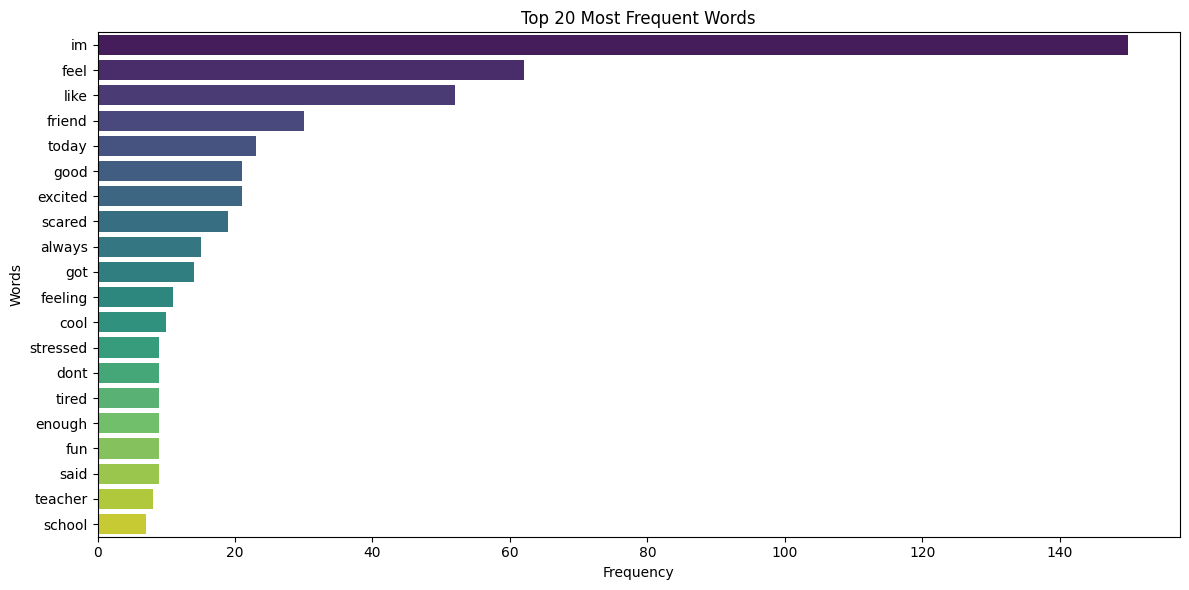

In [ ]:
def plot_frequent_words(df, col, top_n=20):
    top_words = frequent_words(df, col, top_n)
    words, counts = zip(*top_words)

    freq_df = pd.DataFrame({'Word': words, 'Frequency': counts})

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Frequency', y='Word', data=freq_df, palette='viridis')
    plt.title(f'Top {top_n} Most Frequent Words')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.show()

plot_frequent_words(teen_mental_health_df, 'cleaned_user_input', top_n=20)

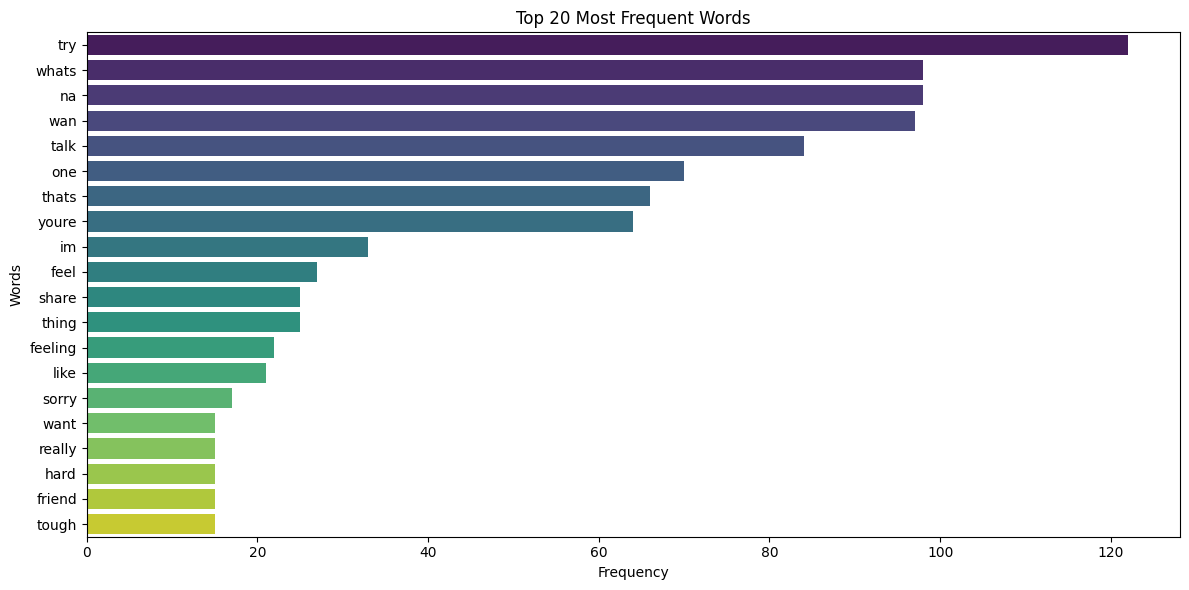

In [ ]:
plot_frequent_words(teen_mental_health_df, 'cleaned_bot_response', top_n=20)


In [ ]:
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures


all_tokens = []
for text in teen_mental_health_df['cleaned_user_input']:
    all_tokens.extend(word_tokenize(text))


bigram_finder = BigramCollocationFinder.from_words(all_tokens)
top_bigrams = bigram_finder.nbest(BigramAssocMeasures.likelihood_ratio, 10)


trigram_finder = TrigramCollocationFinder.from_words(all_tokens)
top_trigrams = trigram_finder.nbest(TrigramAssocMeasures.likelihood_ratio, 10)

print("Top Bigrams (Collocation):", top_bigrams)
print("Top Trigrams (Collocation):", top_trigrams)

Top Bigrams (Collocation): [('feel', 'like'), ('like', 'im'), ('im', 'excited'), ('im', 'scared'), ('got', 'cool'), ('today', 'friend'), ('always', 'left'), ('im', 'tired'), ('last', 'night'), ('im', 'always')]
Top Trigrams (Collocation): [('feel', 'like', 'im'), ('listen', 'feel', 'like'), ('feel', 'like', 'running'), ('apps', 'feel', 'like'), ('dying', 'feel', 'like'), ('eat', 'feel', 'like'), ('expectation', 'feel', 'like'), ('feel', 'like', 'disappoint'), ('feel', 'like', 'let'), ('feel', 'like', 'loser')]


In [ ]:
# Create an NLTK Text object
text_obj = nltk.Text(all_tokens)

# Show concordance for a keyword (e.g., 'feel')
text_obj.concordance("friend", width=60, lines=10)


Displaying 10 of 30 matches:
stressed exam feel anxious friend dont talk anymore im tired
t heart always racing dont friend dont want eat feel like im
ng test everyones prettier friend ditched im done school fee
cry reason im jealous best friend feel like let parent im sc
im always nervous dont fit friend im skipping lunch feel muc
 im worried ill never bfgf friend fake sometimes im bad spor
ys left read im bad making friend feel like im quiet im stre
ng im scared disappointing friend feel like im always stress
different im scared losing friend feel like im lovable im ti
scared feel like im enough friend im stressed fitting feel l


# **Sentiment Analysis**

# Sentiment Analysis Using Vader
* Uses a bag of words approach
* It gives a compound score , negative , positive and neutral scores


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
teen_mental_health_df['user_sentiment'] = teen_mental_health_df['cleaned_user_input'].apply(lambda x: analyzer.polarity_scores(x)['compound']>0 and 'Positive' or analyzer.polarity_scores(x)['compound']<0 and 'Negative' or 'Neutral')

In [ ]:
print(teen_mental_health_df['user_sentiment'])

0      Negative
1      Negative
2      Negative
3      Positive
4      Negative
         ...   
282    Positive
283    Positive
284    Positive
285    Positive
286    Positive
Name: user_sentiment, Length: 287, dtype: object


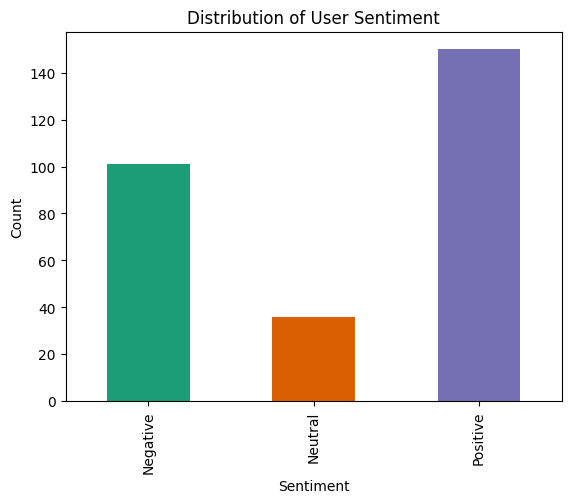

In [ ]:
teen_mental_health_df.groupby('user_sentiment')['user_input'].count().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of User Sentiment')
plt.show()

In [ ]:
res = {}
from tqdm.notebook import tqdm

for i, row in tqdm(teen_mental_health_df.iterrows(), total=len(teen_mental_health_df)):
    try:
        text = row['cleaned_bot_response']
        res[i] = analyzer.polarity_scores(text)
    except RuntimeError:
        pass

print(res)


  0%|          | 0/287 [00:00<?, ?it/s]

{0: {'neg': 0.173, 'neu': 0.533, 'pos': 0.293, 'compound': 0.2263}, 1: {'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'compound': -0.3612}, 2: {'neg': 0.217, 'neu': 0.435, 'pos': 0.348, 'compound': 0.0516}, 3: {'neg': 0.391, 'neu': 0.46, 'pos': 0.149, 'compound': -0.4767}, 4: {'neg': 0.154, 'neu': 0.676, 'pos': 0.17, 'compound': 0.044}, 5: {'neg': 0.0, 'neu': 0.342, 'pos': 0.658, 'compound': 0.6908}, 6: {'neg': 0.139, 'neu': 0.52, 'pos': 0.341, 'compound': 0.5989}, 7: {'neg': 0.405, 'neu': 0.324, 'pos': 0.27, 'compound': -0.3612}, 8: {'neg': 0.0, 'neu': 0.622, 'pos': 0.378, 'compound': 0.5945}, 9: {'neg': 0.385, 'neu': 0.441, 'pos': 0.174, 'compound': -0.4432}, 10: {'neg': 0.385, 'neu': 0.615, 'pos': 0.0, 'compound': -0.3612}, 11: {'neg': 0.176, 'neu': 0.521, 'pos': 0.302, 'compound': 0.2975}, 12: {'neg': 0.425, 'neu': 0.472, 'pos': 0.102, 'compound': -0.6249}, 13: {'neg': 0.337, 'neu': 0.51, 'pos': 0.153, 'compound': -0.2023}, 14: {'neg': 0.102, 'neu': 0.355, 'pos': 0.543, 'compound': 0.827

In [ ]:
vaders_df = pd.DataFrame.from_dict(res, orient='index')
teen_mental_health_df = teen_mental_health_df.join(vaders_df,how='left')
teen_mental_health_df.head()

,user_input,bot_response,cleaned_user_input,cleaned_bot_response,user_sentiment,neg,neu,pos,compound
0,I feel really sad today,I'm so sorry to hear that. Can you share what’...,feel really sad today,im sorry hear share whats going,Negative,0.173,0.533,0.293,0.2263
1,I’m stressed about exams,That sounds overwhelming. Let’s talk about wha...,im stressed exam,sound overwhelming let talk whats stressing,Negative,0.333,0.667,0.000,-0.3612
2,I feel anxious,I hear you. It’s okay to feel anxious sometime...,feel anxious,hear okay feel anxious sometimes want tell,Negative,0.217,0.435,0.348,0.0516
3,My friends don’t talk to me anymore,That must hurt. I'm here for you. Want to talk...,friend dont talk anymore,must hurt im want talk happened,Positive,0.391,0.460,0.149,-0.4767
4,I’m so tired of everything,I'm really sorry you're feeling this way. You'...,im tired everything,im really sorry youre feeling way youre alonei...,Negative,0.154,0.676,0.170,0.0440


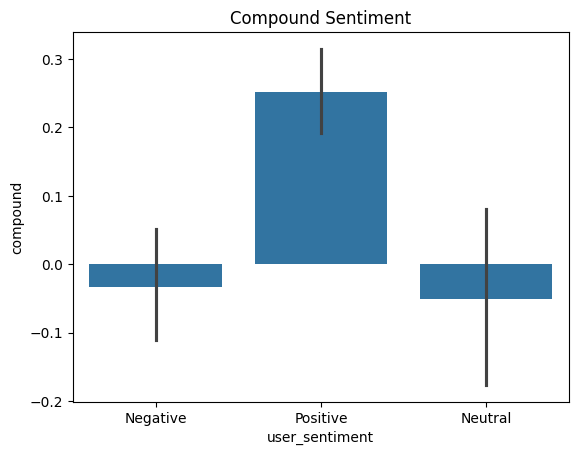

In [ ]:
ax=sns.barplot(data=teen_mental_health_df,x='user_sentiment',y='compound')
ax.set_title('Compound Sentiment')
plt.show()

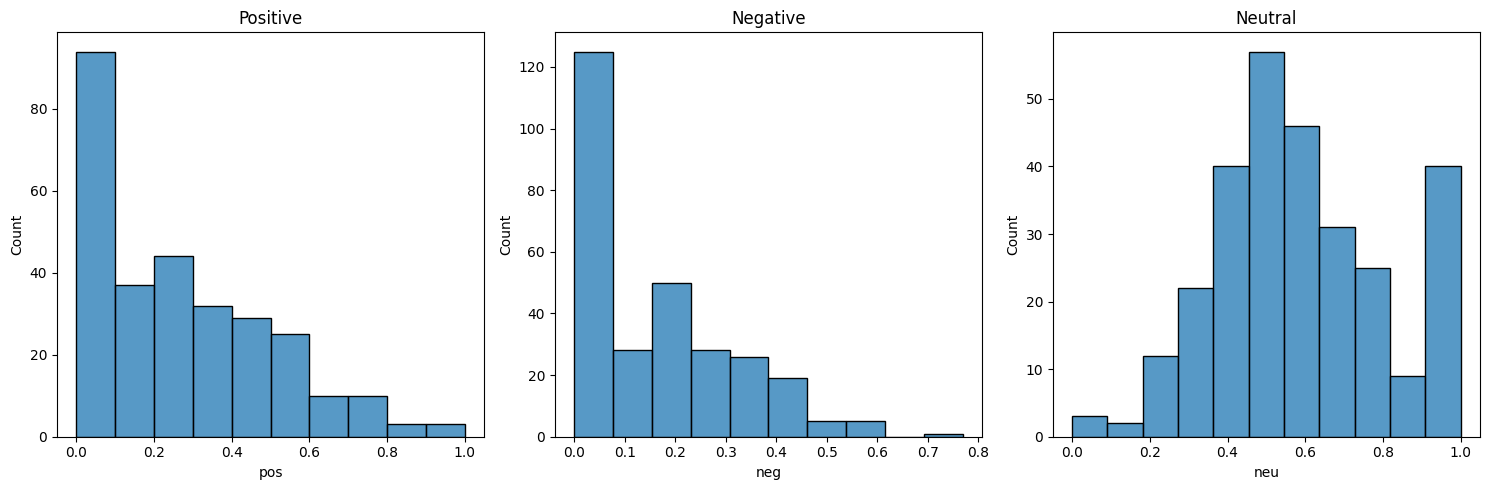

In [ ]:
fig,axs=plt.subplots(1,3,figsize=(15,5))
sns.histplot(vaders_df['pos'],ax=axs[0])
sns.histplot(vaders_df['neg'],ax=axs[1])
sns.histplot(vaders_df['neu'],ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Negative')
axs[2].set_title('Neutral')
plt.tight_layout()
plt.savefig('sentiment.jpg')
plt.show()

 1. **Positive Sentiment Distribution**
> Most scores are between 0.0 and 0.2, indicating that the majority of bot responses have low positivity.

> A small number of responses have scores above 0.6, suggesting some strongly positive messages, but they are relatively rare.

 **Interpretation**:
* The bot generally maintains a low-key supportive tone
* It responds with few highly enthusiastic or cheerful messages — possibly to remain empathetic rather than overly cheerful.


---



 2. **Negative Sentiment Distribution**
> A large peak at 0.0–0.1: most responses have very low negativity.

> Only a few responses exceed 0.4–0.5, and almost none go beyond 0.7.

 **Interpretation**:
`The chatbot is carefully avoiding negative language, which is expected and appropriate in mental health contexts.`


---



3. **Neutral Sentiment Distribution**
> The scores are more evenly spread, with a peak around 0.5, and many values between 0.3 to 0.7.

> Some responses are highly neutral (0.9–1.0) — possibly more factual or non-emotional.

**Interpretation**:
`The chatbot responses are primarily neutral in tone, which aligns with maintaining balance, objectivity, and emotional safety during mental health conversations.`


---


**Sentiment	Key Insights**
1. **Negative** : 	Most responses are non-negative, as expected in a supportive context.
2. **Neutral**: 	The chatbot relies heavily on neutral language, which is often seen in calming or informational responses.
3. **Positive	Positivity** is present but generally mild — the bot avoids sounding overly upbeat, possibly to stay relatable.



---





> One issue with vader sentiment analyzer is that it doesn't take context into account

> So we will compare vaders result to Roberta Pre Trained model which accounts for context too .

# Using Roberta For Sentiment Analysis

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
def polarity_scores_roberta(example):
    encoded_text=tokenizer(example,return_tensors='pt')
    output=model(**encoded_text)
    scores=output[0][0].detach().numpy()
    scores=softmax(scores)
    scores_dict={
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2]
    }
    return scores_dict

In [ ]:
for i,row in tqdm(teen_mental_health_df.iterrows(),total=len(teen_mental_health_df)):
    try:
        text=row['cleaned_bot_response']
        roberta_result=polarity_scores_roberta(text)
        for key,value in roberta_result.items():
            teen_mental_health_df.loc[i,key]=value
    except RuntimeError:
        pass
teen_mental_health_df.head()

  0%|          | 0/287 [00:00<?, ?it/s]

,user_input,bot_response,cleaned_user_input,cleaned_bot_response,user_sentiment,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos
0,I feel really sad today,I'm so sorry to hear that. Can you share what’...,feel really sad today,im sorry hear share whats going,Negative,0.173,0.533,0.293,0.2263,0.615344,0.352218,0.032438
1,I’m stressed about exams,That sounds overwhelming. Let’s talk about wha...,im stressed exam,sound overwhelming let talk whats stressing,Negative,0.333,0.667,0.000,-0.3612,0.606177,0.357983,0.035840
2,I feel anxious,I hear you. It’s okay to feel anxious sometime...,feel anxious,hear okay feel anxious sometimes want tell,Negative,0.217,0.435,0.348,0.0516,0.266459,0.670101,0.063440
3,My friends don’t talk to me anymore,That must hurt. I'm here for you. Want to talk...,friend dont talk anymore,must hurt im want talk happened,Positive,0.391,0.460,0.149,-0.4767,0.819045,0.172519,0.008436
4,I’m so tired of everything,I'm really sorry you're feeling this way. You'...,im tired everything,im really sorry youre feeling way youre alonei...,Negative,0.154,0.676,0.170,0.0440,0.652610,0.306303,0.041087


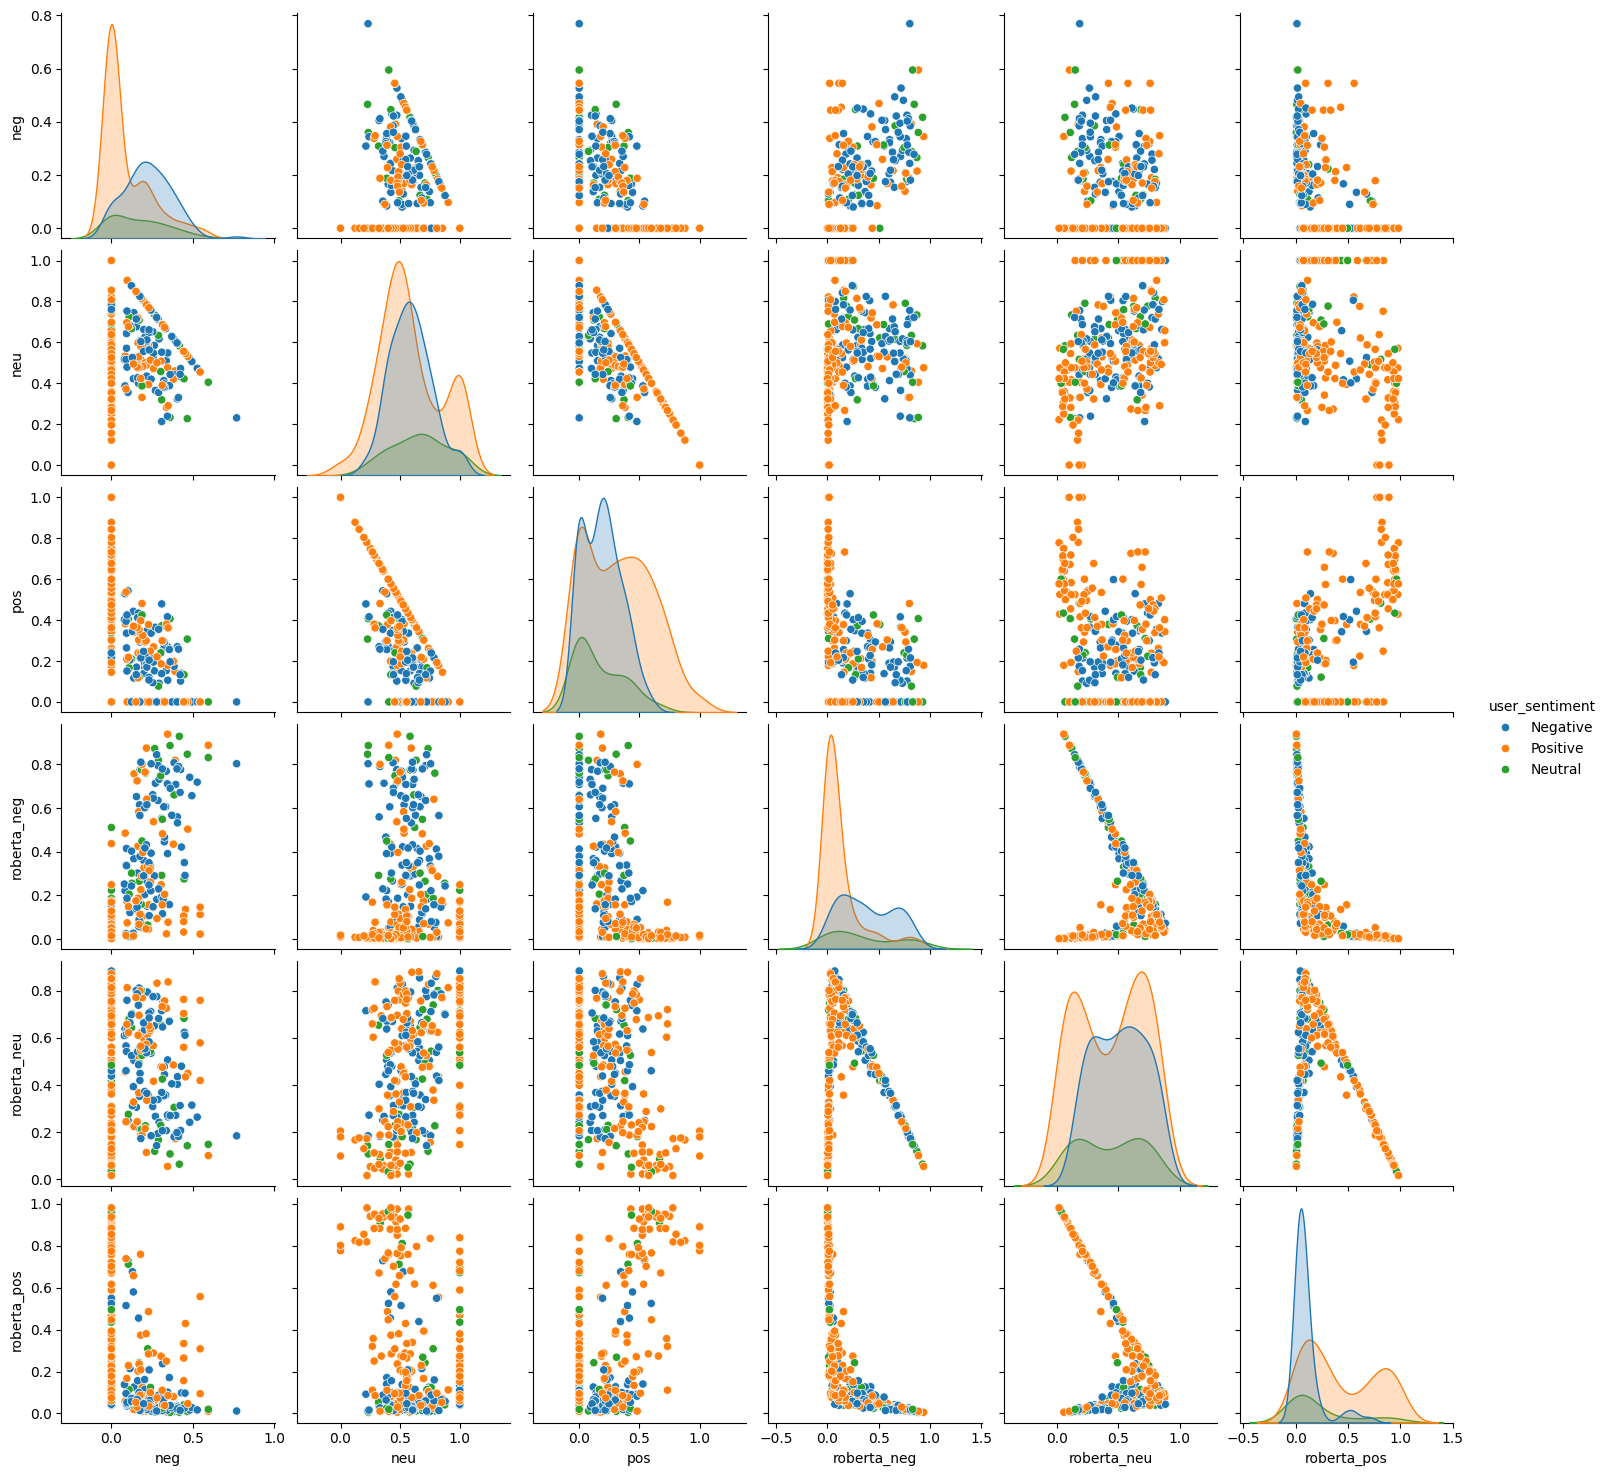

In [ ]:
sns.pairplot(data=teen_mental_health_df,vars=['neg','neu','pos','roberta_neg','roberta_neu','roberta_pos'],hue='user_sentiment',palette='tab10')
plt.savefig('Roberta_Vs_Vader.jpg')
plt.show()

***Key Inferences from the Plot***
1. **VADER vs RoBERTa Distributions**

> VADER scores (neg, neu, pos) are mostly well spread and mutually exclusive (neg vs pos shows a clear inverse relationship).

> RoBERTa scores are more concentrated and less sharply defined — more probabilistic than rule-based VADER.


---



2. **Diagonal KDE plots**

`The diagonal plots show density distributions of each sentiment score`:

* VADER pos has a wide distribution, with Positive-labeled points peaking at higher values.

* RoBERTa pos shows a narrow, steep spike: it's more confident and binary, which is typical of deep learning models.

* VADER neu is flatter; RoBERTa neu shows sharper bimodality — may reflect stronger neutral decisions.


---


3. **Off-Diagonal Scatter Plots**
 > **neg vs pos and roberta_neg vs roberta_pos**:

* Clearly negatively correlated, as expected — when negative is high, positive is low.

* RoBERTa shows more saturation, i.e., values near 0 or 1, reflecting high model confidence.


---


**VADER and RoBERTa comparisons**:

> VADER pos and RoBERTa pos have some agreement but are not perfectly correlated.

> Similarly for neg — RoBERTa may classify strong negations more sharply than VADER.


---



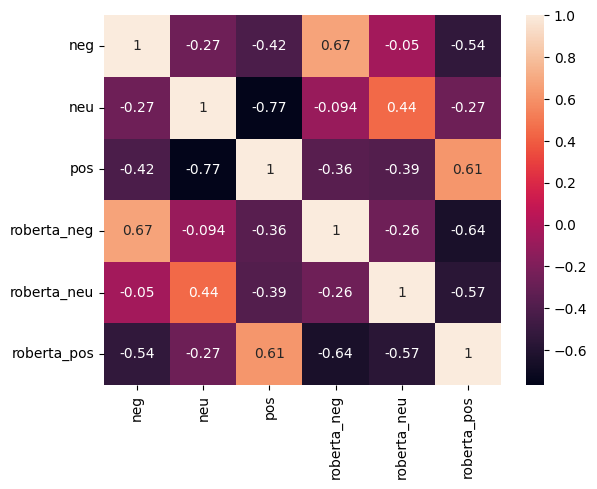

In [ ]:
sns.heatmap(teen_mental_health_df[['neg', 'neu', 'pos', 'roberta_neg', 'roberta_neu', 'roberta_pos']].corr(), annot=True)
plt.show()

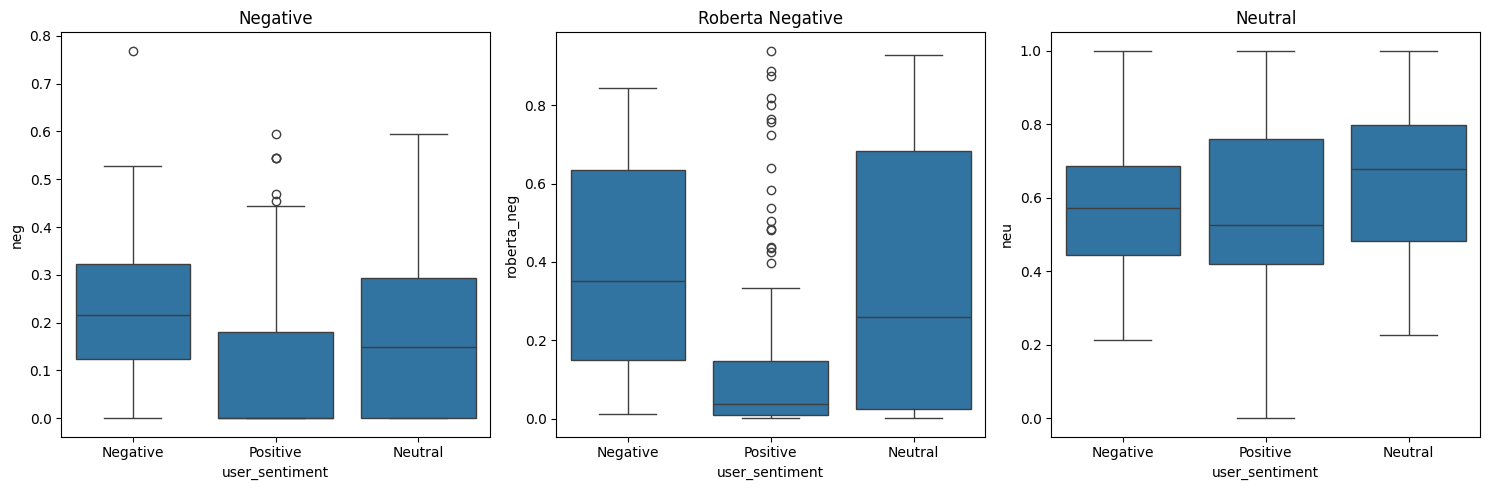

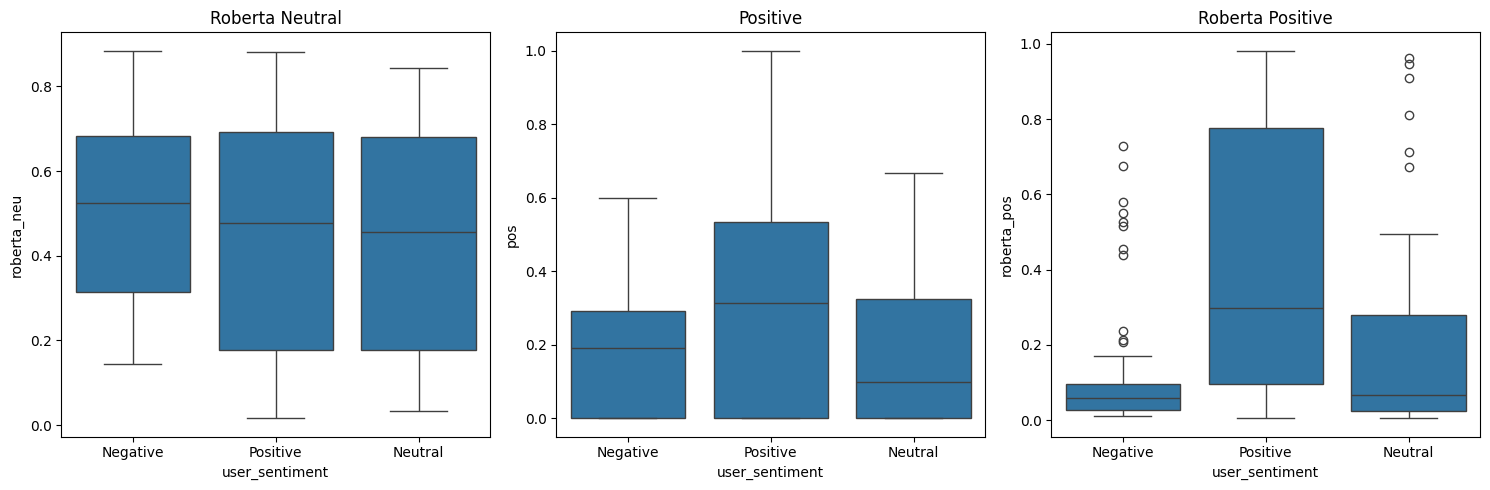

In [ ]:
fig,axs=plt.subplots(1,3,figsize=(15,5))
sns.boxplot(x='user_sentiment',y='neg',data=teen_mental_health_df,ax=axs[0])
sns.boxplot(x='user_sentiment',y='roberta_neg',data=teen_mental_health_df,ax=axs[1])
sns.boxplot(x='user_sentiment',y='neu',data=teen_mental_health_df,ax=axs[2])

axs[0].set_title('Negative')
axs[1].set_title('Roberta Negative')
axs[2].set_title('Neutral')

plt.tight_layout()

#########################
fig,axs=plt.subplots(1,3,figsize=(15,5))
sns.boxplot(x='user_sentiment',y='roberta_neu',data=teen_mental_health_df,ax=axs[0])
sns.boxplot(x='user_sentiment',y='pos',data=teen_mental_health_df,ax=axs[1])
sns.boxplot(x='user_sentiment',y='roberta_pos',data=teen_mental_health_df,ax=axs[2])
axs[0].set_title('Roberta Neutral')
axs[1].set_title('Positive')
axs[2].set_title('Roberta Positive')
plt.tight_layout()
plt.show()


1. **VADER Negative (neg)**

> `Median neg score is higher for user-labeled Negative responses compared to others`.

> `But some Positive-labeled responses also have high neg scores → VADER can misclassify certain emotional language.`

> `Distribution overlaps across all labels → moderate separation.`


---



2. **RoBERTa Negative (roberta_neg)**

> `Clearer separation than VADER`:

> `Highest medians for Negative-labeled data.`

> `Positive and Neutral have much lower scores with tighter ranges.`

> `Outliers for Positive and Neutral → some misclassifications, but generally well-separated.`


---


*  **Inference**: `RoBERTa is more confident and effective at detecting negative sentiment than VADER.`


---



3. **VADER Neutral (neu)**

> `All sentiment classes have similarly high neu scores.`

> `Median values are tightly clustered → VADER overuses neutral scores, making it less discriminative.`

**Issue:** VADER may over-rely on neutrality, especially in emotionally complex messages.


---


4. **RoBERTa Neutral (roberta_neu)**

> `Still shows some overlap, but better spread across sentiment classes.`

> `Slightly lower median for Positive compared to Negative and Neutral.`


---



* **Inference:** `RoBERTa neutral scores are more balanced and offer slightly better class differentiation than VADER.`


---


5. **VADER Positive (pos)**

> `Positive-labeled responses have higher pos scores than others, as expected.`

> `However, overlap remains — Negative and Neutral responses also show non-negligible pos scores.`

> `VADER may detect surface-level positivity (e.g., “I’m okay”) even in negative contexts.`


---



6. **RoBERTa Positive (roberta_pos)**

> `Excellent separation`

> `Positive-labeled responses have very high positive scores.`

> `Negative and Neutral have low medians, especially Negative.`

> `Few outliers in Negative → minimal noise.`


---


* **Inference**: `RoBERTa is highly confident and effective at recognizing positive sentiment.`


---



# Final Insights

**Part 1: Mental Health of teenagers
Using sentiment analysis (VADER + RoBERTa) on children's user_input, we can draw the following inferences**:

 1. *Predominantly Neutral or Negative Tone*

`Many inputs were classified as neutral or negative, indicating`:

> A sense of emotional numbness, confusion, or resignation

> Presence of stress, sadness, anxiety, or loneliness

> High neutrality can also mean they mask emotions or use non-expressive language, which is common in adolescents dealing with mental stress.


---


2. *Subtle Positive Inputs*

> Fewer inputs had strong positive sentiment.

> Even “I'm fine” or “okay” might be false positives, as emotionally distressed users often understate their feelings.


---



3. *Topics of Concern (from Bigrams/Trigrams)*
`A phrase frequency analysis (like "feel alone", "no friends", "not happy"), it likely reinforces`:

> Social isolation

> Academic or parental pressure

> Identity or mental health struggles


---


**Conclusion**: Many children in the dataset show low or mixed emotional valence, consistent with symptoms of emotional suppression, depression, or mild to moderate distress.


---


---




**Part 2: Effectiveness of Bot Responses
The bot's responses were analyzed using VADER and RoBERTa . Here's what we can infer**:

1. *Responses Skew Heavily Neutral*

> Most bot responses have high neutral scores and low negative scores, which is good for avoiding harm but may seem robotic or impersonal.


---


2. *Moderate Positive Sentiment*

> Some responses are gently positive, which is helpful — bots should aim for empathetic encouragement, not toxic positivity.

> RoBERTa identified a few strongly positive responses — this suggests the bot does try to uplift the user, but selectively.


---


3. *Lack of Deep Emotional Mirroring*

`If users are expressing genuine distress (as shown by negative or neutral inputs), the bot's overly-neutral replies may feel emotionally mismatched.`

> Good therapy bots often use mirroring + validating language like:

`“That sounds really difficult. I'm here with you.”`



---


**Conclusion**:
`The bot is safe and non-triggering, but could be improved by':

> Using slightly more empathetic language

> Offering active listening cues or follow-up prompts

> Matching the emotional tone of user inputs more closely



---



---

